In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
from scipy.optimize import curve_fit
import scipy.stats
plt.style.use('dark_background')

In [2]:
#@title Import data
#create a list of all the files in the folder
DIR = "../data/energia/LOB_ottobre21/LOB_ottobre21/"
lob_files =os.listdir(DIR)
lob_files.sort()
lst_order = []
for element in lob_files:
    # import data
    df = pd.read_csv(DIR+ element)
    df.fillna(0, inplace = True)

    # delete first two column and empty LOB
    df.drop(columns = ["Unnamed: 0", "key"], inplace = True)
    df.drop(df[df["AskPrice_0"] == 0].index.to_list(), inplace = True)
    df.drop(df[df["BidPrice_0"] == 0].index.to_list(), inplace = True)

    # scale price to dollar cent and add mid price and spread
    df["MidPrice"] = (df["BidPrice_0"] + df["AskPrice_0"]) / 2
    df["Spread"] = df["AskPrice_0"] - df["BidPrice_0"]

    # transform the column Datetime from string to datetime
    df["Datetime"]= pd.to_datetime(df["Datetime"])

    #create a new column that represent second to midnight 
    seconds = np.zeros(len(df))
    for i, date in enumerate(df["Datetime"]):
        seconds[i] = date.second + 60 * date.minute + 3600 * date.hour + \
                                    date.microsecond * 1e-6
    df["Time"] = seconds


    df = df.loc[df["Datetime"].dt.day != 27]
    
    lst_order.append(df)

clean_data = pd.concat(lst_order)
clean_data.reset_index(inplace = True, drop = True)

message = pd.read_csv("../data/energia/order/best_matching.csv",
                      index_col = 0)

message["DateTime"] = pd.to_datetime(message["DateTime"])
data = pd.concat([clean_data, message[["Price", "Volume", "Sign", "Quote", "Type"]]], axis = 1)

data = data.loc[data["Datetime"].dt.hour > 6]
data = data.loc[data["Datetime"].dt.hour < 16]
data = data.loc[data["Quote"] != "NoBest"]
data = data.loc[data["Spread"] > 0]

data.reset_index(inplace = True, drop = True)

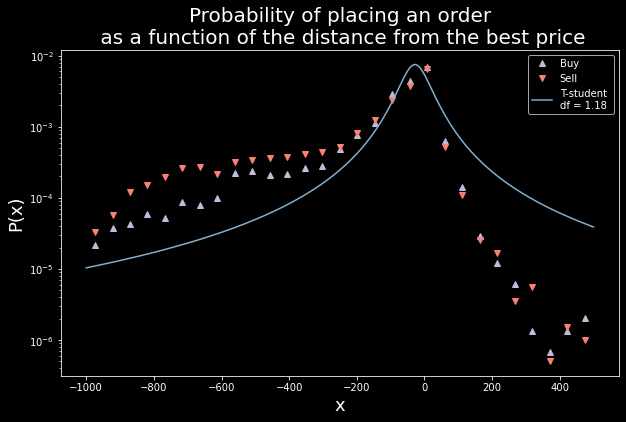

In [52]:
#@title Distribution order placement
fig, ax = plt.subplots(1, 1, figsize = (10,6))

bid_orders = data[(data["Sign"] == 1) & (data["Type"] == "Limit")].index.to_numpy()
bid_orders[0] = 2

best_bid = data["BidPrice_0"].loc[bid_orders - 1].multiply(100). to_numpy()
bid_price =  data["Price"].loc[bid_orders].multiply(100).to_numpy()

log_distance =  bid_price - best_bid
n_b, bins_b, _ = plt.hist(log_distance, density = True, bins = np.linspace(-1000 , 500 , 30), alpha = 0)

ask_orders = data[(data["Sign"] == -1) & (data["Type"] == "Limit")].index.to_numpy()

best_ask = data["AskPrice_0"].loc[ask_orders - 1].multiply(100). to_numpy()
ask_price =  data["Price"].loc[ask_orders].multiply(100).to_numpy()

log_distance_a = best_ask - ask_price
n_a, bins_a, _ = plt.hist(log_distance_a, density = True, bins = np.linspace(-1000 , 500 , 30), alpha = 0)


x_a = (bins_a[1:] + bins_a[:-1]) / 2
x_b = (bins_b[1:] + bins_b[:-1]) / 2
plt.plot(x_b, n_a, ls= "", marker = "^", label = "Buy")
plt.plot(x_a, n_b, ls= "", marker = "v", label = "Sell")

xx = np.linspace(-1000,500,200)
df, l, s = scipy.stats.t.fit(log_distance_a)
plt.plot(xx, scipy.stats.t.pdf(xx, df, loc = l, scale = s), label =f"T-student \ndf = {df:.2f}")

plt.ylabel("P(x)", fontsize = 18)
plt.xlabel("x", fontsize = 18)
plt.title("Probability of placing an order\n as a function of the distance from the best price", fontsize= 20)
plt.yscale("log")
plt.legend()

plt.show()

In [ ]:
data["BuyVolume"] = data.iloc[:,2:40:4].sum(axis=1)
data["SellVolume"] = data.iloc[:,4:44:4].sum(axis=1)
data["TotVolume"] = data["BuyVolume"] + data["SellVolume"]
mean_vol = data["TotVolume"].mean()
mean_canc = data["Volume"].mean()

In [55]:
#@title Distribution order placement

days = pd.unique(data["Datetime"].dt.day)
df = np.zeros(days.shape[0])
l = np.zeros(days.shape[0]) 
s = np.zeros(days.shape[0])
rate_l = np.zeros(days.shape[0])
rate_m = np.zeros(days.shape[0])
rate_c = np.zeros(days.shape[0])

for i,dd in enumerate(days):
    
    new_df = data[data["Datetime"].dt.day == dd]
    new_df.reset_index(drop = True, inplace = True)
    
    bid_orders = new_df[(new_df["Sign"] == 1) & (new_df["Type"] == "Limit")].index.to_numpy()
    bid_orders[0] = 2

    best_bid  = new_df["BidPrice_0"].loc[bid_orders - 1].multiply(100). to_numpy()
    bid_price = new_df["Price"].loc[bid_orders].multiply(100).to_numpy()

    log_distance =  bid_price - best_bid
    
    ask_orders = new_df[(new_df["Sign"] == -1) & (new_df["Type"] == "Limit")].index.to_numpy()
    ask_orders[0] = 2
    best_ask = new_df["AskPrice_0"].loc[ask_orders - 1].multiply(100). to_numpy()
    ask_price =  new_df["Price"].loc[ask_orders].multiply(100).to_numpy()

    log_distance_a = best_ask - ask_price
    
    df[i], l[i], s[i] = scipy.stats.t.fit(log_distance_a)
    
    mean_vol = new_df["TotVolume"].mean()
    mean_canc = new_df["Volume"].mean()
    
    tot_time = (16 - 7) * 3600 

    rate_l[i] = new_df[new_df["Type"] == "Limit"].shape[0] / tot_time
    rate_m[i] = new_df[new_df["Type"] == "Market"].shape[0] / tot_time
    rate_c[i] = new_df[new_df["Type"] == "Cancel"].shape[0] / tot_time / mean_vol * mean_canc
   

In [64]:
params = pd.DataFrame(days, columns = ["Day"])
params["DF"] = df
params["Loc"] = l
params["Scale"] = s
params["RateLim"] = rate_l
params["RateMark"] = rate_m
params["RateCanc"] = rate_c

params.to_csv("..\main\MikeFarmer.csv")


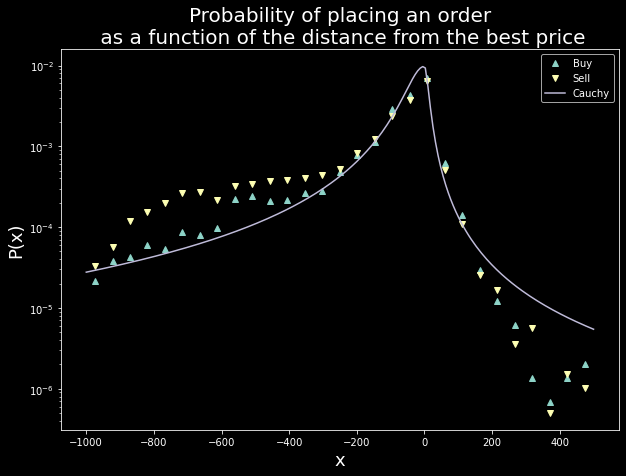

In [26]:
sk, l, s = scipy.stats.skewcauchy.fit(log_distance_a)
fig, ax = plt.subplots(1, 1, figsize = (10,7))

plt.plot(x_b, n_a, ls= "", marker = "^", label = "Buy")
plt.plot(x_a, n_b, ls= "", marker = "v", label = "Sell")

xx = np.linspace(-1000,500,200)

plt.ylabel("P(x)", fontsize = 18)
plt.xlabel("x", fontsize = 18)
plt.title("Probability of placing an order\n as a function of the distance from the best price", fontsize= 20)
plt.yscale("log")


plt.plot(xx, scipy.stats.skewcauchy.pdf(xx, sk , loc = l, scale = s), label =f"Cauchy", alpha= 1)
plt.yscale("log")
plt.legend()
plt.show()


In [30]:
s

32.54033705861379

In [7]:
data["BuyVolume"] = data.iloc[:,2:40:4].sum(axis=1)
data["SellVolume"] = data.iloc[:,4:44:4].sum(axis=1)
data["TotVolume"] = data["BuyVolume"] + data["SellVolume"]
mean_vol = data["TotVolume"].mean()
mean_canc = data["Volume"].mean()

In [8]:
days = pd.unique(data["Datetime"].dt.day)
seconds = np.zeros(days.shape[0])
for i,dd in enumerate(days):
    min_sec = data.loc[data["Datetime"].dt.day == dd, ["Time"]].min()
    max_sec = data.loc[data["Datetime"].dt.day == dd, ["Time"]].max()
    seconds[i] = max_sec - min_sec
    

tot_time = seconds.sum()

rate_l = data[data["Type"] == "Limit"].shape[0] / tot_time
rate_m = data[data["Type"] == "Market"].shape[0] / tot_time
rate_c = data[data["Type"] == "Cancel"].shape[0] / tot_time / mean_vol * mean_canc

In [10]:
def linear(x,m):
    return m * x

In [11]:
data["TimeDiff"] = data["Time"].diff().fillna(0)
data["TimeDiff"].loc[data["TimeDiff"] < 0] = 0

C:\Users\spina\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [12]:
canc = data[data["Type"] == "Cancel"]
limito = data[data["Type"] == "Limit"]
marco = data[data["Type"] == "Market"]

Text(0.5, 0, 'Spread')

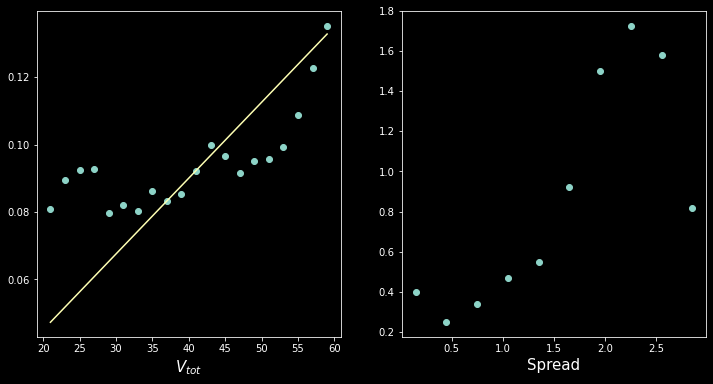

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))
hh = canc.groupby("TotVolume")["Volume"].count() / data.groupby("TotVolume")["TimeDiff"].sum()
aa = hh.index.to_numpy()
bb = hh.fillna(0).to_numpy()

bm, bc, _ = scipy.stats.binned_statistic(aa, bb, bins = 20, range=(20,60))
xx = 0.5 * (bc[1:] + bc[:-1])
ax[0].plot(xx, bm, marker = "o", ls= "")
ax[0].set_xlabel(r"$V_{tot}$", fontsize = 15)

popt, pcov = curve_fit(linear, xx, bm)
ax[0].plot(xx, linear(xx,*popt))


hh = canc.groupby("Spread")["Volume"].count() / data.groupby("Spread")["TimeDiff"].sum()
hh.fillna(0, inplace = True)
aa = hh.index.to_numpy()
bb = hh.to_numpy()

bm, bc, _ = scipy.stats.binned_statistic(aa, bb, bins = 10, range=(0,3))
xx = 0.5 * (bc[1:] + bc[:-1])

ax[1].plot(xx, bm, marker="o", ls = "")
ax[1].set_xlabel("Spread", fontsize = 15)




In [14]:
popt*mean_canc

array([0.00820936])

Text(0.5, 0, 'Spread')

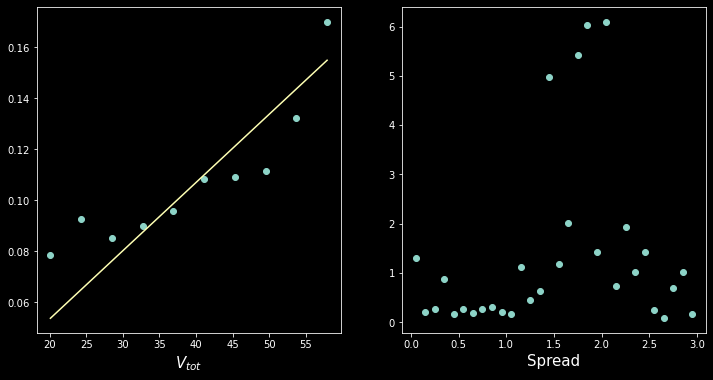

In [32]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))
hh = limito.groupby("TotVolume")["Volume"].count() / data.groupby("TotVolume")["TimeDiff"].sum()
aa = hh.index.to_numpy()
bb = hh.fillna(0).to_numpy()

bm, bc, _ = scipy.stats.binned_statistic(aa, bb, bins = 10, range=(18,60))
xx = 0.5 * (bc[1:] + bc[:-1])
ax[0].plot(xx, bm, marker = "o", ls= "")
ax[0].set_xlabel(r"$V_{tot}$", fontsize = 15)

popt, pcov = curve_fit(linear, xx, bm)
ax[0].plot(xx, linear(xx,*popt))


hh = limito.groupby("Spread")["Volume"].count() / data.groupby("Spread")["TimeDiff"].sum()
hh.fillna(0, inplace = True)
aa = hh.index.to_numpy()
bb = hh.to_numpy()

bm, bc, _ = scipy.stats.binned_statistic(aa, bb, bins = 30, range=(0,3))
xx = 0.5 * (bc[1:] + bc[:-1])

ax[1].plot(xx, bm, marker="o", ls = "")
ax[1].set_xlabel("Spread", fontsize = 15)

In [16]:
popt

array([0.00267545])

array([0.        , 0.        , 0.08376823, 0.10691407, 0.05050299,
       0.08731889, 0.08845474, 0.0649782 , 0.06872107, 0.08282158,
       0.09447648, 0.09102918, 0.08627756, 0.09930673, 0.08843993,
       0.07911658, 0.08293986, 0.09044357, 0.08412413, 0.09159235,
       0.08841491, 0.09522773, 0.09564723, 0.09772222, 0.09415388,
       0.09614831, 0.09790255, 0.09591964, 0.11456412, 0.10978432,
       0.12377926, 0.11490322, 0.10902271, 0.10478962, 0.10751889,
       0.12156276, 0.09972284, 0.10224721, 0.12246786, 0.12168715,
       0.12876212, 0.13779683, 0.14008702, 0.1574705 , 0.16918036,
       0.1795947 , 0.13776896, 0.20591741, 0.16519539, 0.1604085 ,
       0.2135934 , 0.16860736, 0.21329512, 0.23967622, 0.25397235,
       0.19126874, 0.31560644, 0.19363811, 0.22002582, 0.53423   ,
       0.17168249, 0.29390049, 0.59104982, 0.21730357, 0.47033232,
       0.33020066, 0.32757052, 0.18683261, 1.00589165, 0.07404254,
       0.85160741, 0.41013022, 0.61115355, 0.21355543, 0.54949

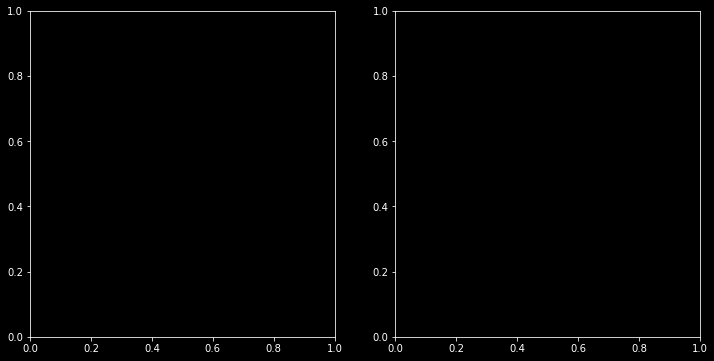

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))
hh = limito.groupby("TotVolume")["Volume"].count() / data.groupby("TotVolume")["TimeDiff"].sum()
aa = hh.index.to_numpy()
bb = hh.fillna(0).to_numpy()

bb

In [ ]:
ff = limito.groupby("TotVolume")["Volume"].count().to_numpy()
gg = limito.groupby("TotVolume")["Volume"].count().index.to_numpy()
plt.plot(gg,ff)

In [ ]:
X_lo = data[(data["Quote"] == "0") & (data["Type"] == "Limit")]
X_mo =data[data["Type"] == "Market"]
X_c = data[(data["Quote"] == "0") & (data["Type"] == "Cancel")]

N_lo = X_lo.shape[0]
N_mo = X_mo.shape[0]
N_c  = X_c.shape[0]
tot = N_lo + N_mo + N_c

v0 = X_lo["Volume"].mean()
V = 0.5 * (data["AskVolume_0"] + data["BidVolume_0"]).mean() 

mu  = 0.5 / tot / v0 * X_mo["Volume"].sum()
all_l = N_lo / tot * 0.5 
n = 2 * (1 + int(X_lo["Spread"].multiply(50).mean()))
lam = all_l / n
v = 0.5 / tot * X_c["Volume"].sum() / V

In [ ]:
print(lam, mu, v)
data[data["Type"] == "Limit"].shape[0] / data.shape[0]